In [1]:
from PIL import Image
import numpy as np
import cv2
from utils import plot_results

import os
from google.cloud import vision
from credentials import google_key

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = google_key
client = vision.ImageAnnotatorClient()

In [8]:
color = "green"
image_directory = f"../images/result_snippets/{color}/"

## Load-Image-Snippets

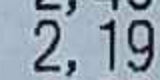

In [9]:
# load all images from given directory and apply OCR

image_snippets = []
for filename in os.listdir(image_directory):
    if filename.endswith(".png"):
        img = cv2.imread(os.path.join(image_directory, filename))
        if img is not None:
            image_snippets.append(img)

plot_results(image_snippets[0], scale=2)

## Compose-A-Large-Canvas-For-Reducing-API-Calls

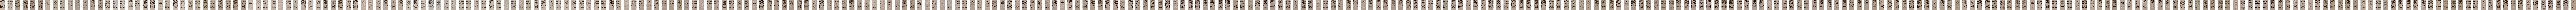

In [10]:
# TODO figure out why background color is suddenly "warmer" than before (has nothing to do with plot_results(), saved image has the same problem)

gap = 20

# Define the dimensions of the canvas (you can adjust these as needed)
max_width = np.max([Image.fromarray(te).width for te in image_snippets])
total_height = np.sum([Image.fromarray(te).height for te in image_snippets])
canvas_width = max_width
canvas_height = total_height + gap * len(image_snippets) - gap

# Create an empty canvas
canvas = Image.new('RGB', (canvas_width, canvas_height), (255, 255, 255))

x_offset = 0
y_offset = 0
for te in image_snippets:
    image = Image.fromarray(te)

    # Paste the image onto the canvas at the calculated position
    canvas.paste(image, (x_offset, y_offset))

    # Calculate the position to paste the image in the center of the canvas
    # x_offset = (x_offset - image.width)
    y_offset = (y_offset + image.height + gap)

# Save or display the final canvas
# canvas.save('output_canvas.png')
plot_results(canvas.rotate(90, expand=True), scale=1.2, mode='popup')

canvas_array = np.array(canvas)

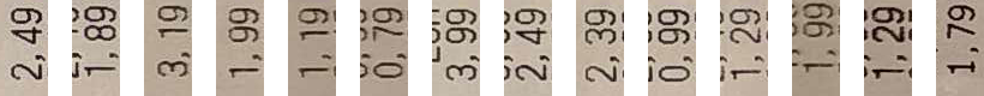

In [7]:
# closer look at the previous output/the composed canvas for reducing API calls

## Google-API-Call

In [11]:
_, image_bytes = cv2.imencode('.png', canvas_array)
image_data = image_bytes.tobytes()
google_image = vision.Image(content=image_data)
response = client.text_detection(image=google_image)
texts = response.text_annotations

In [23]:
text = texts[0].description
print(text[:25])

2, 19
3.99
3,59
2,95
0,65


## Post-Processing

In [24]:
text = text.replace(",", "_")
text = text.replace(".", "_")
text = text.replace(" ", "")
text = text.split("\n")
# drop value if no . is present
text = [t for t in text if "_" in t]
# check if text contains any numbers
text = [t for t in text if any(char.isdigit() for char in t)]
display(len(text), text[:5])

343

['2_19', '3_99', '3_59', '2_95', '0_65']

## Validation

In [19]:
# TODO temporary solution!

print(len(image_snippets), len(text))
assert len(text) == len(image_snippets)

343 343


## Save_Values

In [143]:
# save image snippets as .png files
for i, img in enumerate(image_snippets[:len(text)]):
    # prevent duplicate filenames
    if 0 <= i < 10:
        cv2.imwrite(f"../images/classified_snippets/{color}/00{i}-{text[i]}.png", img)
    if 10 <= i < 100:
        cv2.imwrite(f"../images/classified_snippets/{color}/0{i}-{text[i]}.png", img)
    if 100 <= i < 1000:
        cv2.imwrite(f"../images/classified_snippets/{color}/{i}-{text[i]}.png", img)

## Load_Values

In [20]:
# get file names from folder
values = os.listdir(f"../images/classified_snippets/{color}/")
values = [f.split("-")[1] for f in values]
values = [f[:-4] for f in values]
values = [float(f.replace("_", ".")) for f in values]
values[:5]

[2.19, 3.99, 3.59, 2.95, 0.65]

## Calculate_Results

In [21]:
for clr in ["orange", "pink", "green"]:
    values = os.listdir(f"../images/classified_snippets/{clr}/")
    values = [f.split("-")[1] for f in values]
    values = [f[:-4] for f in values]
    values = [float(f.replace("_", ".")) for f in values]
    print(f"{clr}: {round(sum(values),2)}€")

orange: 342.18€
pink: 27.76€
green: 833.13€
